In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# import some learn-to-rank method
from sharp import ShaRP
import pandas as pd
import lightgbm as lgb

# utility functions
from sharp.utils import scores_to_rank
from mlresearch.utils import set_matplotlib_style

set_matplotlib_style(42, **{"font.family":"Times"})

# Define functions

In [2]:
# def calculate_relevance(ranks):
#     """Converts a rank vector to a relevance score"""
#     relevance_scores = 1 - ranks / ranks.shape[0]
#     return relevance_scores

# data
We use the "movers" data from
Yang, Ke, Joshua R. Loftus, and Julia Stoyanovich. "Causal intersectionality for fair ranking." arXiv preprint arXiv:2006.08688 (2020).

In [3]:
file = 'R10_test_ranklib.txt'
df = pd.read_csv(file,delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta'])

In [4]:
df

,relevance,qid,gender,race,X,Y,meta
0,0,qid:2,1:0,2:1,3:0.4547080342442664,4:0.1493783886120043,#docid=612;rel=0;g=M;r=B;
1,0,qid:2,1:0,2:0,3:-0.21525739269349048,4:-0.13378755098479744,#docid=14;rel=0;g=M;r=W;
2,0,qid:2,1:1,2:0,3:-1.9623749803589363,4:-1.669096830997429,#docid=1976;rel=0;g=F;r=W;
3,0,qid:2,1:1,2:0,3:-1.9021488120278065,4:-1.6891155915219045,#docid=1338;rel=0;g=F;r=W;
4,0,qid:2,1:1,2:1,3:-1.1430592245104003,4:-1.1920751624984351,#docid=508;rel=0;g=F;r=B;
...,...,...,...,...,...,...,...
1995,0,qid:2,1:0,2:1,3:-0.777299958766823,4:-0.53623404864515,#docid=82;rel=0;g=M;r=B;
1996,0,qid:2,1:1,2:1,3:-0.7257625091182793,4:-0.6211059452086105,#docid=1349;rel=0;g=F;r=B;
1997,0,qid:2,1:0,2:1,3:-0.5307201799590591,4:-0.4962429107884686,#docid=728;rel=0;g=M;r=B;
1998,0,qid:2,1:1,2:0,3:-1.1942232147034475,4:-1.058724419238001,#docid=75;rel=0;g=F;r=W;


In [5]:
df['qid'] = df['qid'].str.replace('qid:', '')
df['gender'] = df['gender'].str.replace('1:', '')
df['race'] = df['race'].str.replace('2:', '')
df['X'] = df['X'].str.replace('3:', '')
df['Y'] = df['Y'].str.replace('4:', '')
df = df.astype({'gender': int, 'race': int, 'X': float, 'Y': float})

In [6]:
df.describe()

,relevance,gender,race,X,Y
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,62.625000,0.370000,0.370000,-0.383572,-0.387979
std,130.316828,0.482925,0.482925,0.951984,0.807035
min,0.000000,0.000000,0.000000,-4.466380,-3.811648
25%,0.000000,0.000000,0.000000,-0.968149,-0.886706
50%,0.000000,0.000000,0.000000,-0.302084,-0.318046
75%,0.250000,1.000000,1.000000,0.260648,0.186854
max,500.000000,1.000000,1.000000,2.480864,1.772666


In [7]:
# train_df = df[:1600].copy()  # first 80%
# validation_df = df[-400:].copy()  # remaining 20%

train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# here I am taking 1st 80000 entries for train but you can use train_test_split
qids_train = train_df.groupby("qid")["qid"].count().to_numpy()
# Create ranking as the "relevance" score
X_train = train_df.sort_values('Y', ascending=False)
n_rows = X_train.shape[0]
X_train['rank'] = range(1, n_rows + 1)
# Assign outcome
y_train = X_train["rank"]
# Drop columns we don't use
X_train = X_train.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)

qids_validation = validation_df.groupby("qid")["qid"].count().to_numpy()
# Create ranking as the "relevance" score
X_validation = validation_df.sort_values('Y', ascending=False)
n_rows = X_validation.shape[0]
X_validation['rank'] = range(1, n_rows + 1)
# Assign outcome
y_validation = X_validation["rank"]
# Drop columns we don't use
X_validation = X_validation.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)


In [8]:
# # https://github.com/microsoft/LightGBM/issues/2892#issuecomment-596525112
# train_df = df[:1600]  # first 80%
# validation_df = df[400:]  # remaining 20%
# # here I am taking 1st 80000 entries for train but you can use train_test_split
# qids_train = train_df.groupby("qid")["qid"].count().to_numpy()
# X_train = train_df.drop(["qid", "Y", "relevance", "meta"], axis=1)
# y_train = train_df["relevance"].copy()
# 
# qids_validation = validation_df.groupby("qid")["qid"].count().to_numpy()
# X_validation = validation_df.drop(["qid", "Y", "relevance", "meta"], axis=1)
# y_validation = validation_df["relevance"].copy()

In [9]:
# Joao: added
y_train[y_train != 0] = scores_to_rank(y_train[y_train != 0], direction=1)
y_validation[y_validation != 0] = scores_to_rank(y_validation[y_validation != 0], direction=1)

In [10]:
model = lgb.LGBMRanker(
    objective="lambdarank",
    # metric="ndcg",
    # min_data_in_leaf=1,
    label_gain=list(range(1601)),# np.unique(y_train.values)
    #verbose=-1
)
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_validation, y_validation)],
    eval_group=[qids_validation],
    eval_at=10,
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank')

In [11]:
relevance = model.predict(X_train)
relevance

array([-9.68686971, -9.68686971, -9.59446698, ...,  4.70428012,
        4.70428012,  4.90647907])

In [12]:
scores_to_rank(relevance, 1), y_train.values

(array([   1,    2,   29, ..., 1598, 1594, 1600]),
 array([   1,    2,    3, ..., 1598, 1599, 1600]))

# Model interpretability

In [13]:
X_train

,gender,race,X
55,0,0,2.034534
1993,0,0,1.844400
64,1,0,2.480864
893,0,0,2.224490
958,0,0,1.913491
...,...,...,...
1317,1,0,-3.278596
682,1,0,-3.786229
1507,1,0,-3.427142
312,1,0,-4.031312


In [26]:
xai = ShaRP(
    qoi="ranking",
    target_function=model.predict,
    measure="shapley",
    sample_size=3, # sample_size=None,
    replace=False,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
xai.fit(X_train)

shapley_values = pd.DataFrame(
    xai.all(X_validation), 
    columns=X_validation.columns, 
    index=X_validation.index
)
shapley_values["score"] = model.predict(X_validation)
shapley_values["ranking"] = scores_to_rank(shapley_values["score"])
shapley_values.to_csv(f"r10_test_ranklib_{xai.qoi_.__class__.__name__.lower()}_shapley_values.csv")

  0%|          | 0/400 [00:00<?, ?it/s]

In [36]:
buckets = 10
shapley_values = pd.read_csv("r10_test_ranklib_rankingqoi_shapley_values.csv", index_col="Unnamed: 0").rename(columns={"X":"qualification"})


shapley_values['rank_bucket'] = [
    (
        str(math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) * 10) 
        + "-\n" 
        + str(math.floor(((rank - 1) / (shapley_values.shape[0] / buckets)) + 1) * 10) 
        + "%" 
    )
    if math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) != 0 
    else "<10%"
    for rank in shapley_values['ranking']
]

shapley_values["Rank Bucket"] = shapley_values["rank_bucket"].str.replace("%", r"\%").str.replace("<", "$<$")
shapley_values = (
    shapley_values
    .drop(columns=["rank_bucket", "ranking", "score"])
    .melt(id_vars=["Rank Bucket"])
    .rename(columns={"variable": "Feature", "value": "Contribution"})
)

shapley_values.sort_values(["Rank Bucket", "Feature"], inplace=True)
shapley_values

,Rank Bucket,Feature,Contribution
313,$<$10\%,gender,148.211250
333,$<$10\%,gender,148.254583
345,$<$10\%,gender,119.339583
351,$<$10\%,gender,147.435417
360,$<$10\%,gender,117.257083
...,...,...,...
536,90-\n100\%,race,-153.415417
550,90-\n100\%,race,-153.415417
552,90-\n100\%,race,-147.728750
558,90-\n100\%,race,-147.728750


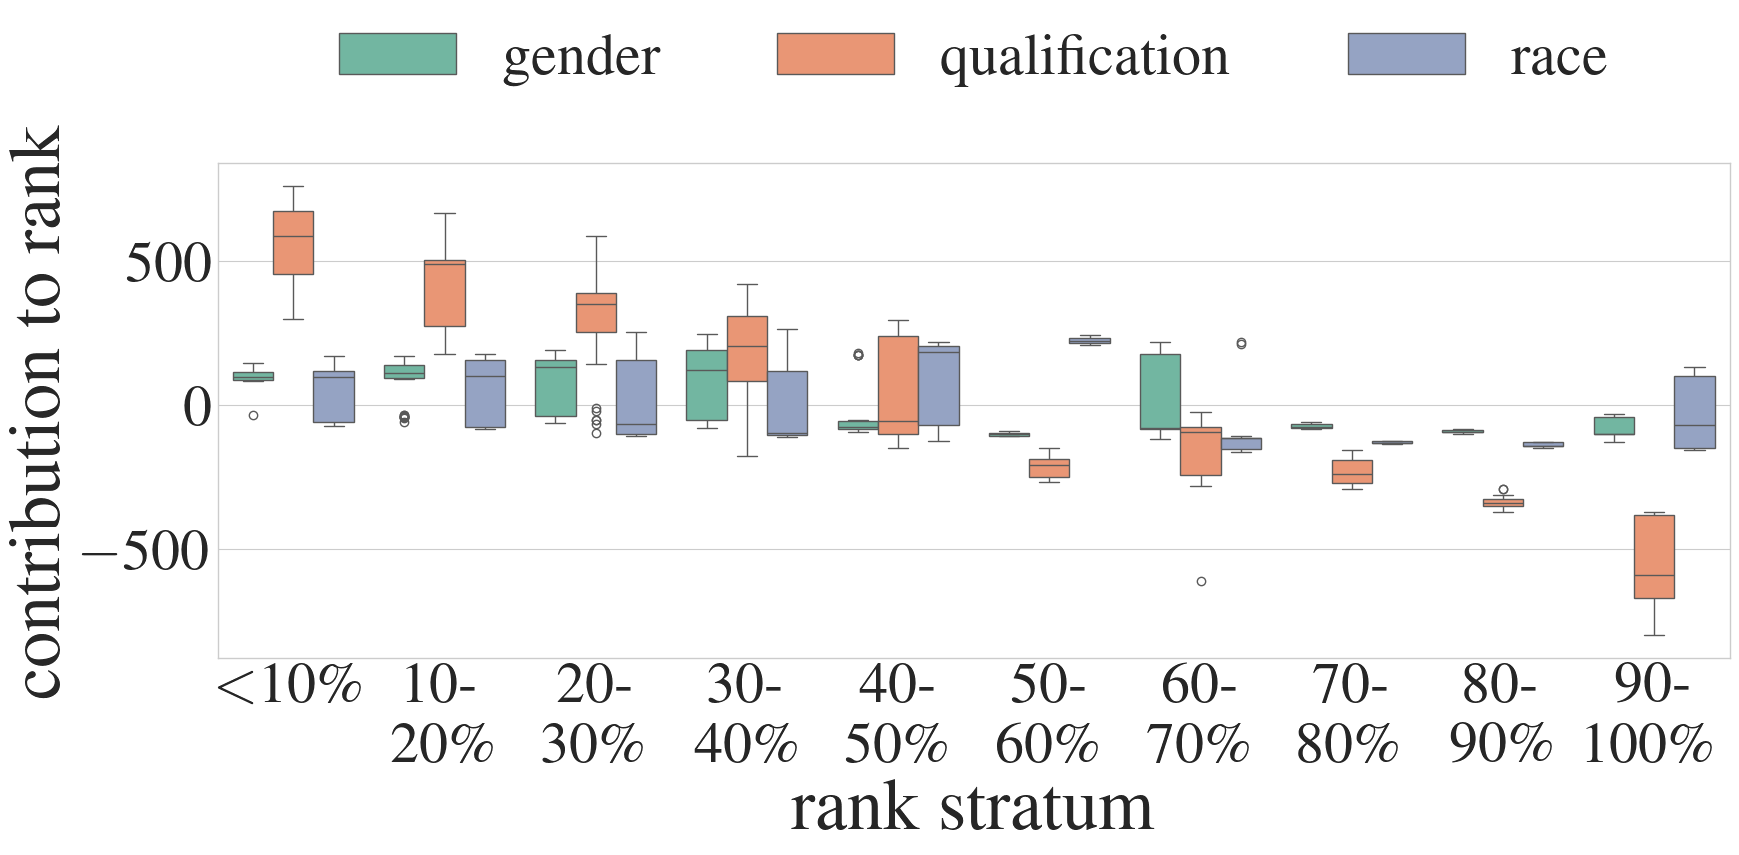

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey='row')
graph = sns.boxplot(
    x=shapley_values['Rank Bucket'], 
    y=shapley_values['Contribution'], 
    hue=shapley_values['Feature'], 
    palette="Set2"
)
graph.set_ylabel("contribution to rank")
graph.set_xlabel("rank stratum")
sns.move_legend(
    graph, "lower center", bbox_to_anchor=(.5, 1.05), ncol=4, title=None, frameon=False,
)

plt.savefig(
    f"r10_contrs_rank.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()